In [3]:
!pip install pandas mlxtend

In [4]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

In [5]:
df = pd.read_csv("cleaned_sales_data.csv")

In [6]:
df['ProductNo'] = df['ProductNo'].astype(str).str.lstrip('C')
df['ProductNo'] = df['ProductNo'].astype(str).str.lstrip('A')
df['ProductNo'] = df['ProductNo'].astype(str).str.lstrip('B')

In [7]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Step 1: Filter top N products by frequency (using ProductNo)
top_product_nos = df['ProductNo'].value_counts().head(500).index.tolist()

# Step 2: Prepare transactions with only top products
transactions = (
    df[df['ProductNo'].isin(top_product_nos)]
    .groupby('TransactionNo')['ProductNo']
    .apply(list)
    .tolist()
)

# Step 3: Encode transactions using sparse=True for memory efficiency
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions, sparse=True)
df_encoded = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)

# Step 4: Run Apriori with max_len and min_support to reduce memory
frequent_itemsets = apriori(
    df_encoded,
    min_support=0.01,
    use_colnames=True,
    max_len=2
)

# Step 5: Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

print(len(rules))

/tmp/ipython-input-7-1828220936.py:18: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_encoded = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)


1582


In [8]:
!pip install seaborn matplotlib

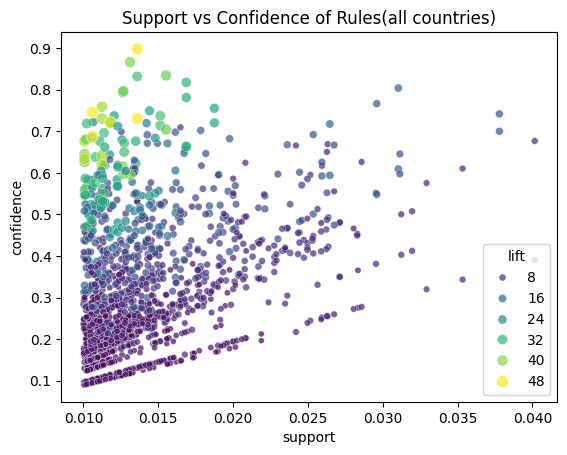

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=rules, x='support', y='confidence', size='lift', hue='lift', palette='viridis', alpha=0.7)
plt.title('Support vs Confidence of Rules(all countries)')
plt.savefig("support vs confidence all countries.png", dpi=300, bbox_inches='tight')
plt.show()

In [36]:
new_rules = rules[rules['confidence'] >= 0.7]
print(len(new_rules))

32


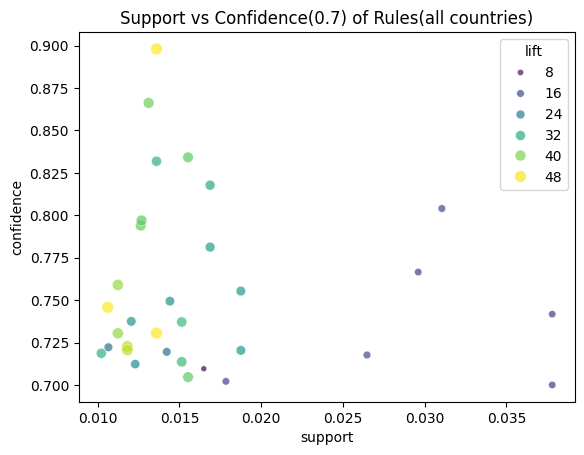

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=new_rules, x='support', y='confidence', size='lift', hue='lift', palette='viridis', alpha=0.7)
plt.title('Support vs Confidence(0.7) of Rules(all countries)')
plt.savefig("support vs confidence(0.7) all countries.png", dpi=300, bbox_inches='tight')
plt.show()

In [38]:
product_map = df[['ProductNo', 'ProductName']].drop_duplicates().set_index('ProductNo')['ProductName'].to_dict()

def map_products(product_set):
    return [product_map.get(item, str(item)) for item in product_set]

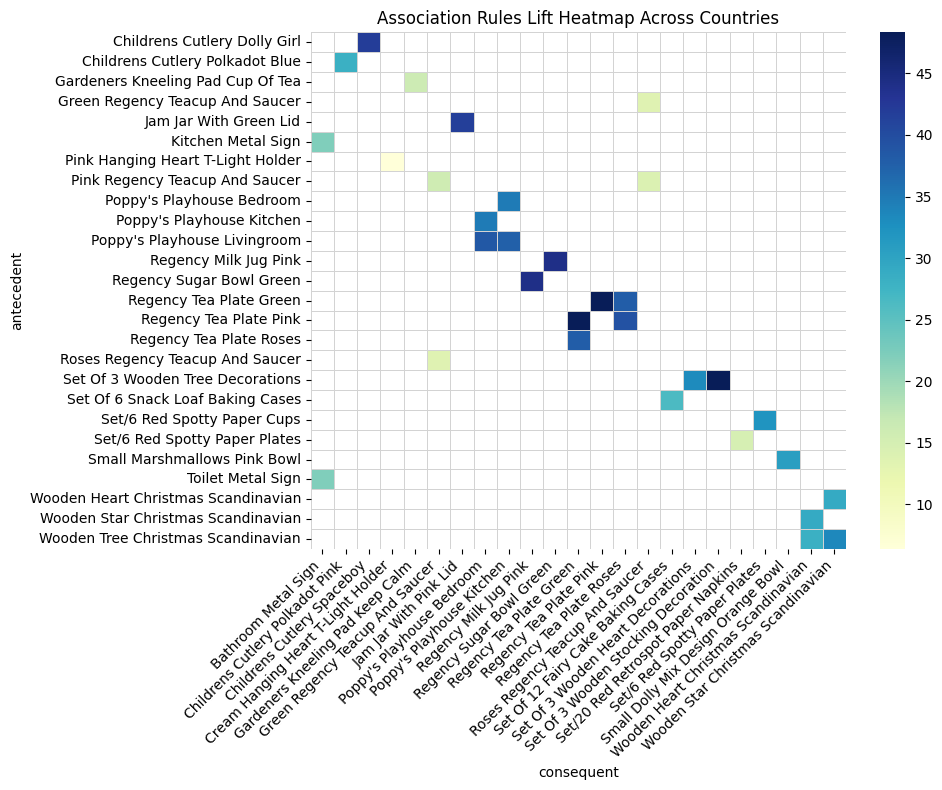

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Apply product name mapping for antecedents and consequents
new_rules = new_rules.copy()
new_rules['antecedents_names'] = new_rules['antecedents'].apply(lambda x: [product_map.get(i, str(i)) for i in x])
new_rules['consequents_names'] = new_rules['consequents'].apply(lambda x: [product_map.get(i, str(i)) for i in x])

# Filter for rules with only 1 item on both sides
pivot = new_rules[
    new_rules['antecedents_names'].apply(lambda x: len(x) == 1) &
    new_rules['consequents_names'].apply(lambda x: len(x) == 1)
].copy()

# Extract names from singleton sets
pivot['antecedent'] = pivot['antecedents_names'].apply(lambda x: x[0])
pivot['consequent'] = pivot['consequents_names'].apply(lambda x: x[0])

# Pivot the DataFrame
heatmap_data = pivot.pivot(index='antecedent', columns='consequent', values='lift')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=False, cmap="YlGnBu", linewidths=0.5, fmt=".2f", linewidth=0.5, linecolor="#D3D3D3")
plt.title("Association Rules Lift Heatmap Across Countries")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("heatmap all countries.png", dpi=300, bbox_inches='tight')
plt.show()

In [42]:
!pip install geopandas

In [59]:
df = pd.read_csv("cleaned_sales_data.csv")
df = df[df['Country'] != 'United Kingdom']
df6 = df[df['Date'] < '2019-06-01']

customer_counts6 = df6.groupby('Country')['CustomerNo'].nunique().reset_index()
customer_counts6.columns = ['country', 'customer_count']
customer_counts = df.groupby('Country')['CustomerNo'].nunique().reset_index()
customer_counts.columns = ['country', 'customer_count']

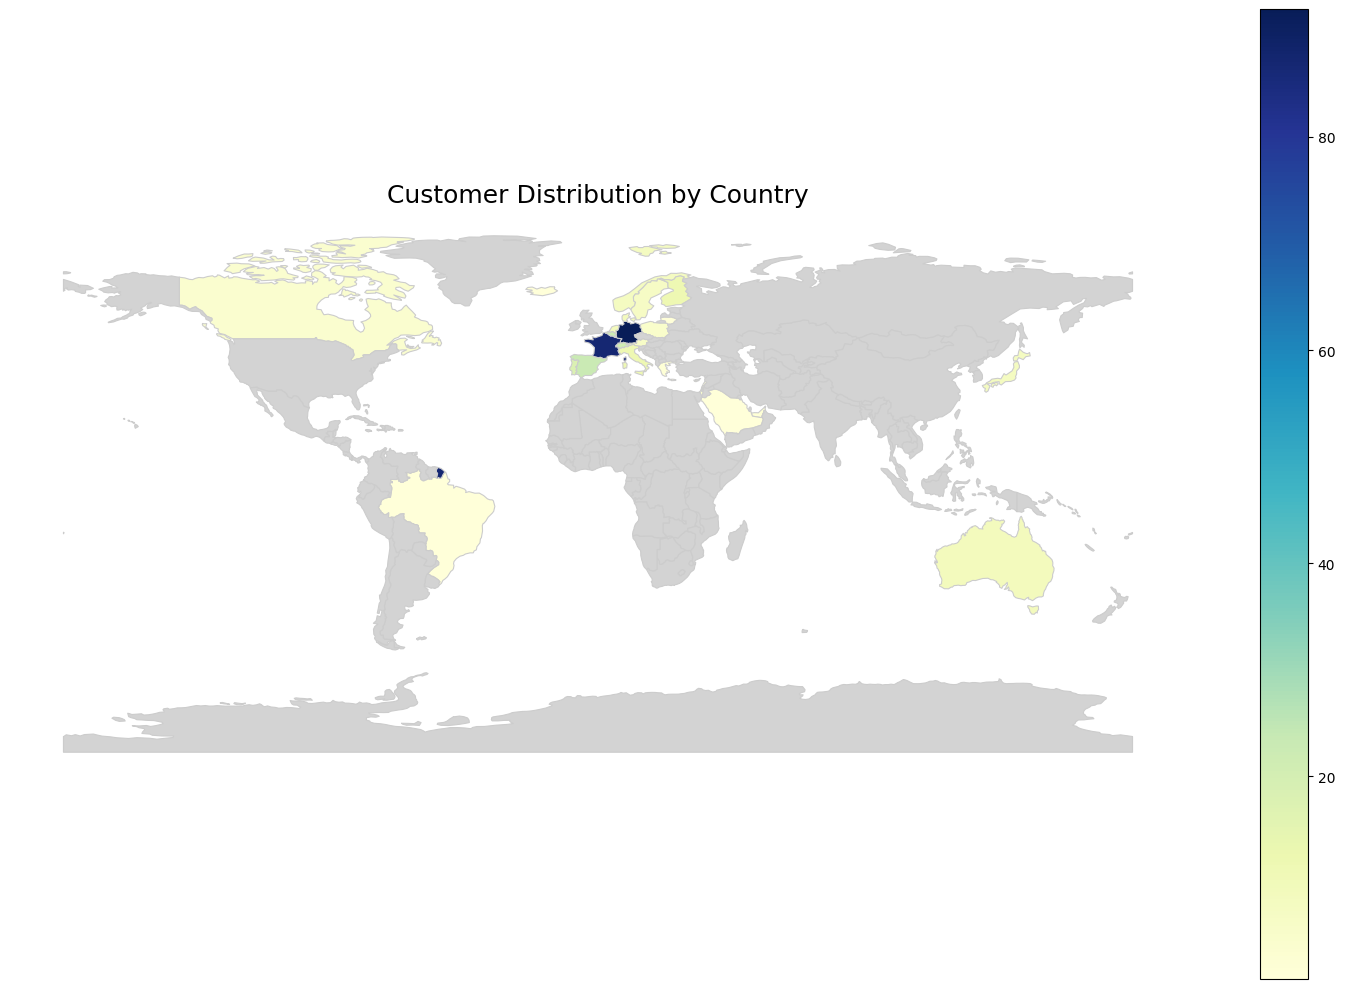

In [64]:
import geopandas as gpd
world = gpd.read_file("/ne_110m_admin_0_countries.shp")
# Step 2: Your customer data
customer_df = customer_counts
# Step 3: Merge customer data with world GeoDataFrame
merged = world.merge(customer_df, how='left', left_on='NAME', right_on='country')

# Step 4: Plot choropleth
fig, ax = plt.subplots(figsize=(15, 10))

# Fill countries by customer count
merged.plot(
    column='customer_count',
    cmap='YlGnBu',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',  # light gray borders
    legend=True,
    missing_kwds={"color": "lightgrey", "label": "No data"}
)

# Add title and clean layout
ax.set_title('Customer Distribution by Country', fontdict={'fontsize': 18})
ax.axis('off')

plt.tight_layout()
plt.show()


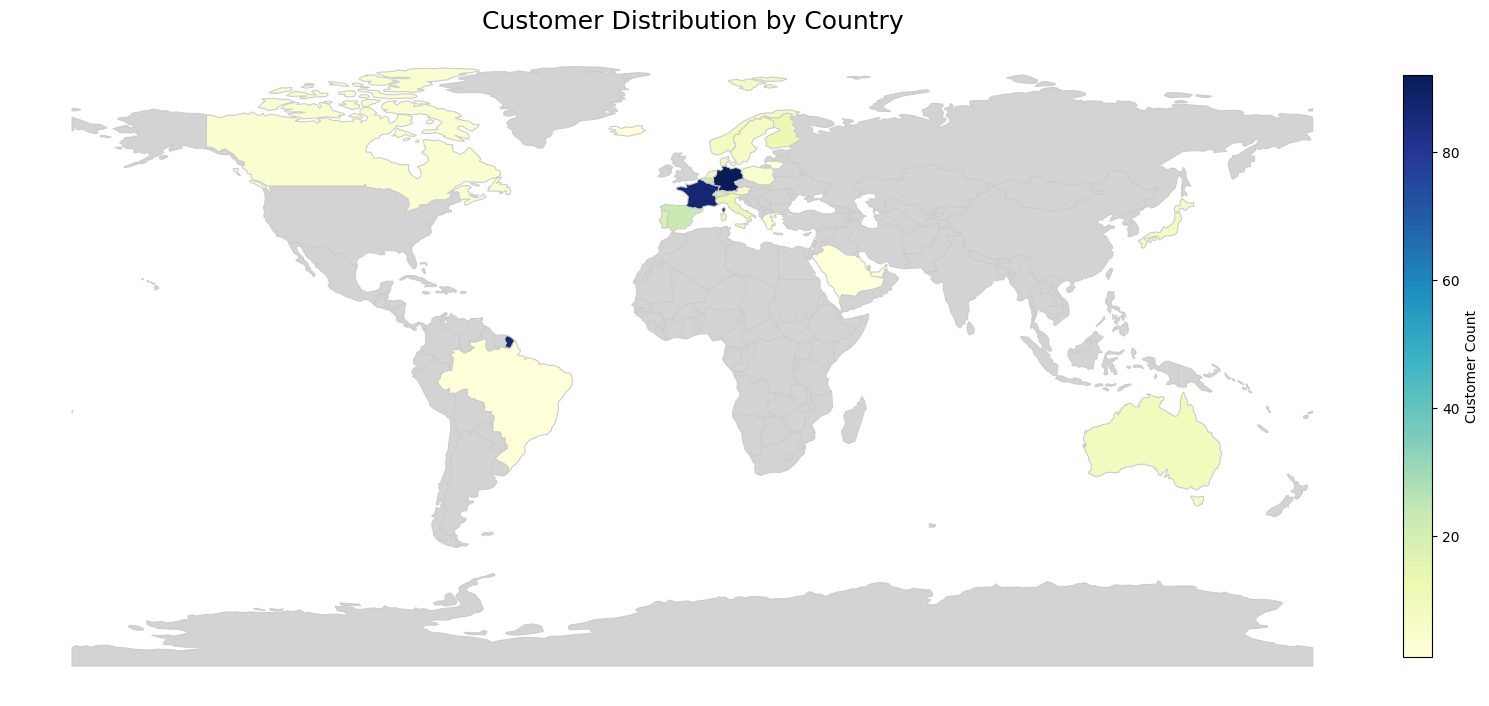

In [65]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib as mpl

# --- Your world + merged data already done ---

fig, ax = plt.subplots(figsize=(15, 10))

# Plot the map without the default legend
merged_plot = merged.plot(
    column='customer_count',
    cmap='YlGnBu',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=False,
    missing_kwds={"color": "lightgrey", "label": "No data"}
)

# Create a scalar mappable for the colorbar
norm = mpl.colors.Normalize(vmin=merged['customer_count'].min(), vmax=merged['customer_count'].max())
sm = mpl.cm.ScalarMappable(cmap='YlGnBu', norm=norm)
sm._A = []  # Required for ScalarMappable in older versions

# Add custom colorbar — control size and position
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.025, pad=0.02, shrink=0.6)
cbar.set_label('Customer Count')

# Final touches
ax.set_title('Customer Distribution by Country', fontsize=18)
ax.axis('off')
plt.tight_layout()
plt.savefig("customer_distribution_map.png", dpi=300)
plt.show()

2822


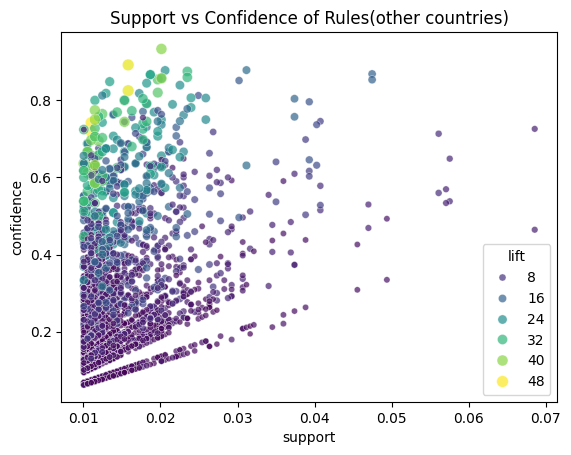

28


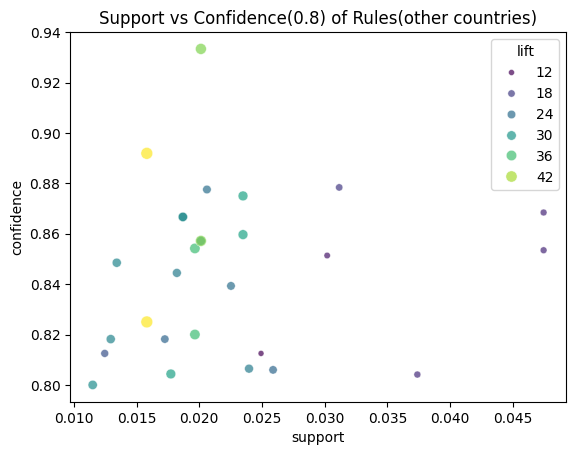

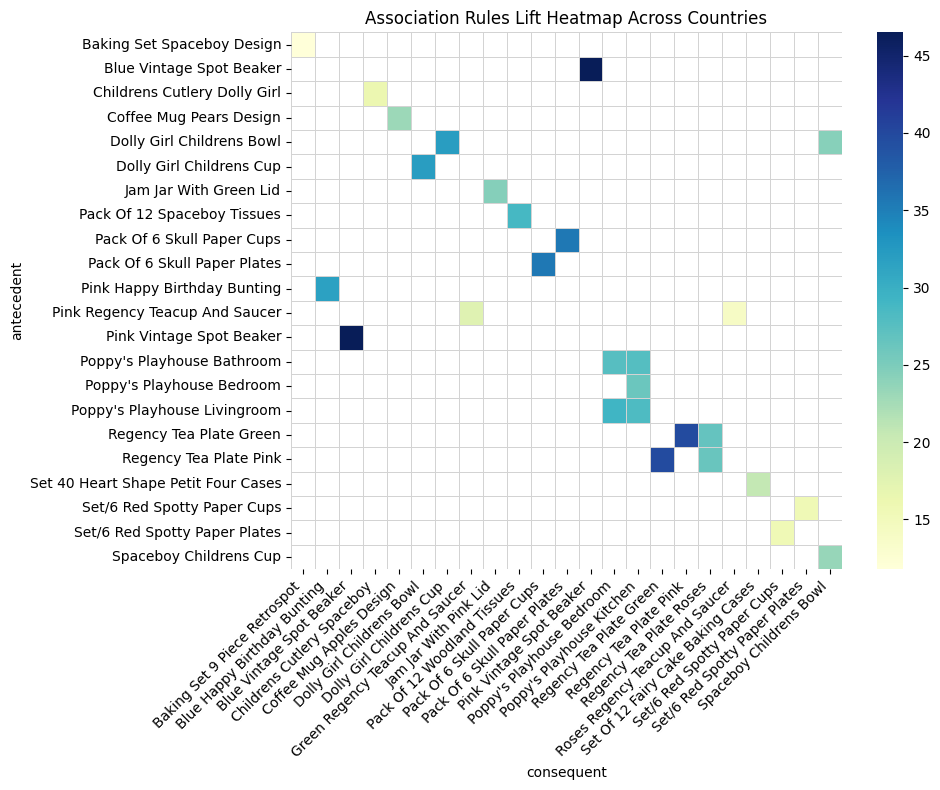

In [67]:
df = pd.read_csv("cleaned_sales_data.csv")
df = df[df['Country']  != 'United Kingdom']
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Step 1: Filter top N products by frequency (using ProductNo)
top_product_nos = df['ProductNo'].value_counts().head(500).index.tolist()

# Step 2: Prepare transactions with only top products
transactions = (
    df[df['ProductNo'].isin(top_product_nos)]
    .groupby('TransactionNo')['ProductNo']
    .apply(list)
    .tolist()
)

# Step 3: Encode transactions using sparse=True for memory efficiency
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions, sparse=True)
df_encoded = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)

# Step 4: Run Apriori with max_len and min_support to reduce memory
frequent_itemsets = apriori(
    df_encoded,
    min_support=0.01,
    use_colnames=True,
    max_len=2
)

# Step 5: Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

print(len(rules))
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=rules, x='support', y='confidence', size='lift', hue='lift', palette='viridis', alpha=0.7)
plt.title('Support vs Confidence of Rules(other countries)')
plt.savefig("support vs confidence other countries.png", dpi=300, bbox_inches='tight')
plt.show()
new_rules = rules[rules['confidence'] >= 0.8]
print(len(new_rules))
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=new_rules, x='support', y='confidence', size='lift', hue='lift', palette='viridis', alpha=0.7)
plt.title('Support vs Confidence(0.8) of Rules(other countries)')
plt.savefig("support vs confidence(0.8) other countries.png", dpi=300, bbox_inches='tight')
plt.show()
product_map = df[['ProductNo', 'ProductName']].drop_duplicates().set_index('ProductNo')['ProductName'].to_dict()

def map_products(product_set):
    return [product_map.get(item, str(item)) for item in product_set]
import seaborn as sns
import matplotlib.pyplot as plt

# Apply product name mapping for antecedents and consequents
new_rules = new_rules.copy()
new_rules['antecedents_names'] = new_rules['antecedents'].apply(lambda x: [product_map.get(i, str(i)) for i in x])
new_rules['consequents_names'] = new_rules['consequents'].apply(lambda x: [product_map.get(i, str(i)) for i in x])

# Filter for rules with only 1 item on both sides
pivot = new_rules[
    new_rules['antecedents_names'].apply(lambda x: len(x) == 1) &
    new_rules['consequents_names'].apply(lambda x: len(x) == 1)
].copy()

# Extract names from singleton sets
pivot['antecedent'] = pivot['antecedents_names'].apply(lambda x: x[0])
pivot['consequent'] = pivot['consequents_names'].apply(lambda x: x[0])

# Pivot the DataFrame
heatmap_data = pivot.pivot(index='antecedent', columns='consequent', values='lift')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=False, cmap="YlGnBu", linewidths=0.5, fmt=".2f", linewidth=0.5, linecolor="#D3D3D3")
plt.title("Association Rules Lift Heatmap Across Countries")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("heatmap other countries.png", dpi=300, bbox_inches='tight')
plt.show()